<a href="https://colab.research.google.com/github/Chiaradisanto/Segmentation/blob/main/ProvaHCMtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
#Load previously saved model
from keras.models import load_model
model = load_model("/gdrive/MyDrive/unetpng.h5", compile=False)

In [3]:
from matplotlib import pyplot as plt
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
#from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, add, concatenate,UpSampling2D,ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [8]:


val_img_path = "/gdrive/MyDrive/TESI/TEST/test/test_images"
val_mask_path = "/gdrive/MyDrive/TESI/TEST/test/test_masks"

In [9]:
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rescale=1/255.,
                     
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict( rescale=1/255.,
                     
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect'
                     
                     ) #Binarize the output again. 



In [10]:
batch_size=16

In [11]:

image_data_generator = ImageDataGenerator(**img_data_gen_args)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)

valid_img_generator = image_data_generator.flow_from_directory(val_img_path, 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               color_mode = 'grayscale', 
                                                               
                                                               target_size=(512,512),
                                                               class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator.flow_from_directory(val_mask_path, 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               target_size=(512,512),
                                                               
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here

val_generator = zip(valid_img_generator, valid_mask_generator)

Found 255 images belonging to 1 classes.
Found 255 images belonging to 1 classes.


In [12]:

test_image_batch, test_mask_batch = val_generator.__next__()

In [13]:
a = valid_img_generator.next()
b = valid_mask_generator.next()

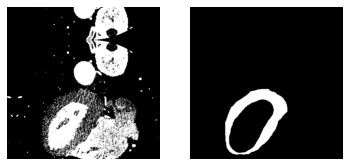

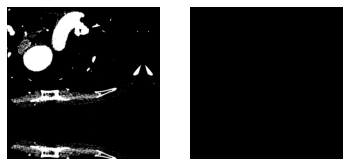

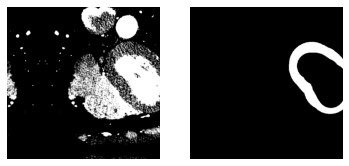

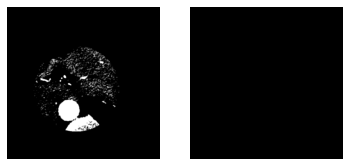

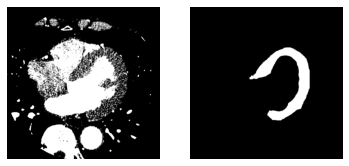

In [14]:
for i in range(0,5):
    image = a[i]
    mask = b[i]
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(mask[:,:,0],cmap='gray')
    plt.show()

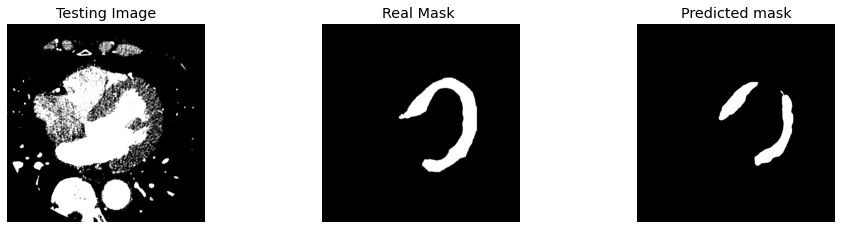

In [31]:
import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.axis('off')
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')


plt.subplot(232)
plt.title('Real Mask ')
plt.axis('off')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.axis('off')
plt.title('Predicted mask')
plt.imshow(prediction, cmap='gray')

plt.show()

In [32]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.75756645


In [33]:
import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)

0.7340184
1.0
0.6900048
1.0
0.75756645
0.55139834
0.48402596
0.7481595
0.7300867
1.0
0.6431403
0.6499913
0.49311256
0.499712
0.6552719
1.0
Mean IoU is:  [0.63637406]
